# Optimizing Camera Placement for Emergency Prevention and Response

Scientific mentors: Matteo Vandelli and Daniele Dragoni (Leonardo S.p.a.)

Here we propose a problem of interest in this field: an optimization problem involving the placement of hyperspectral cameras used in the prevention of natural disasters and in emergency response.
The formulation of the problem is a simplified one, which has important connections with real-world scenarios.

Simplifying assumptions are: 
- The field of view of the cameras is isotropic, while in reality it depends on the morphology of the territory.
- The risk of a natural disaster occurring on the territory of choice is homogeneous.

We have $N$ candidate sites and $C$ available antennas (we assume that $C=0$ means no constraint).

The corresponding Ising problem has the following form, in terms of the Ising binary variables $z_i \in \{-1, 1\}$:

\begin{align}
H_C(z) &= \sum\limits_{i<j}^N W_{ij} z_i z_j - \xi \sum\limits_{i=1}^N A_i z_i\\
& \text{s.t.} 
\hspace{1cm}\left\{\begin{matrix}
\sum\limits_{i=1}^N z_i = N - 2C    \hspace{1.5cm}&\text{if $C>0$}\\
\text{none}   &\text{if $C=0$}
\end{matrix}\right.
\end{align}



where 
- $W_{ij}$ is the overlap area between the fields of view of two cameras,
- $A_i$ is the area covered by a camera at site $i$,
- $\xi$ is a positive real number to be suitably tuned.

This problem has been proposed in Ref.[1] in the context of antenna placement.
This "spin ILP" problem can be written in the unconstrained form:
\begin{align}
H_P(z) = H_C(z) + P\left(\sum\limits_{i=1}^N z_i - \delta N\right)^2
\end{align}
where $P \geq 0$ is a penalty term that has to be chosen large enough to obtain a ground state with the correct number of cameras, but not too large otherwise the optimization becomes more complicated. In this case, $P=0$ means that the problem is unconstrained.

Your job is to study the performances of the TN algorithms (variational and/or imaginary-time) for **both** the *constrained* and *unconstrained* cases.


[1] *Evaluating the Practicality of Quantum Optimization Algorithms for Prototypical Industrial Applications*,
M. Vandelli, A. Lignarolo, C. Cavazzoni, D. Dragoni, arXiv:2311.11621 (2023)


In [1]:
# Loading libraries to handle the problem
from ocp import *

In [2]:
# number of sites
# N = 10
sizes = [9,10]

xi_list = [.25]

# number of cameras
C = 1
P = 0.0

# side of the square defining the simplified model
a = 10

num_shots = 1000 # shots for measuring the bitstring
max_bond_dim = 32
cut_ratio = 1e-6
max_iter = 250
tn_type = 6 # (5)TTN, (6)MPS
tensor_backend = 2
statics_method = 4 #1 : sweep, 2 : sweep with space expansion, 4 : imaginary time evolution with TDVP space expansion
                #5 : imaginary time evolution with TDVP single-site, 33 : imaginary nearest-neighbor TEBD.

seed=42

#set seed
np.random.seed(1)

sweep_order=None
# sweep_order=[]
# for i in range(int(np.log2(N)-1)):
#     for j in range(int(2**(i+1))):
#         sweep_order.append((i,j))
# random.shuffle(sweep_order)


In [3]:
params, dlist, mlist, slist = everythin_else(sizes, C, P, xi_list, a, seed, 
                                            max_bond_dim, cut_ratio, max_iter, statics_method, tn_type, tensor_backend, num_shots)


params =  {'N': 9, 'xi': 0.25}
Starting simulation input
==================== Contraction summary iTPO (indexing=True, compress=False) ====================
Count (0, 1) = 144
Count (1, 2) = 639
Count (2, 3) = 923
Count (3, 4) = 1136
Count (4, 5) = 1420
Count (5, 6) = 1491
Count (6, 7) = 1278
Count (7, 8) = 1278
Count (8, 7) = 284
Count (7, 6) = 710
Count (6, 5) = 781
Count (5, 4) = 923
Count (4, 3) = 1207
Count (3, 2) = 1278
Count (2, 1) = 1349
Count (1, 0) = 576
Count 0 = 1470
Count None = 14451
Count 1 = 4128
Count 2 = 5320
Count 3 = 6138
Count 4 = 6850
Count 5 = 6600
Count 6 = 5418
Count 7 = 4446
Count 8 = 1233
Total contractions: 71471
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Simulation time is 5.5127.

params :  {'N': 9, 'xi': 0.25}
Energy =  -54.60162509675855
Proj Meas =  {'110000010': 1000}
params =  {'N': 10, 'xi': 0.25}
Starting simulation input
==================== Contraction summary iTPO (indexing=True, compress=False) ====================
Count (0, 1) 

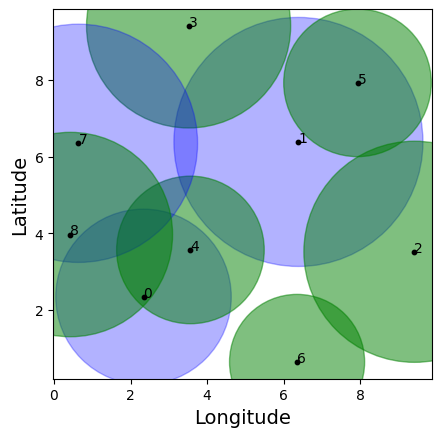

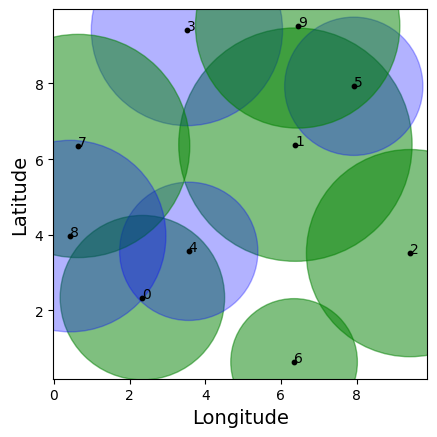

In [4]:
results = []
for ii, elem in enumerate(params):
    print('params = ', elem)
    
    # run the simulation
    start_time = time.time()
    slist[ii].run(elem, delete_existing_folder=True)
    dt_tn = time.time() - start_time
    # get the results
    results.append( slist[ii].get_static_obs(elem) )

    energy = results[ii]['energy']
    proj = results[ii]['projective_measurements']

    print('\nparams : ', elem)
    print('Energy = ', energy)
    print('Proj Meas = ', proj)
    
    bit_string_list=[]
    cnt=0
    for bit in proj.keys():
        bit_string_list.append([*bit])
        plot_antennas(dlist[ii], status=bit_string_list[cnt])
        plt.savefig('camera_placement_N'+str(elem['N'])+'_xi'+str(elem['xi'])+'_.pdf',bbox_inches='tight')
        cnt+=1


7.849933862686157 0.029064655303955078 [-54.6016251  -50.87602959 -49.64926829]
7.849933862686157 0.10224533081054688 [-52.20842701 -50.0044591  -48.17555184]


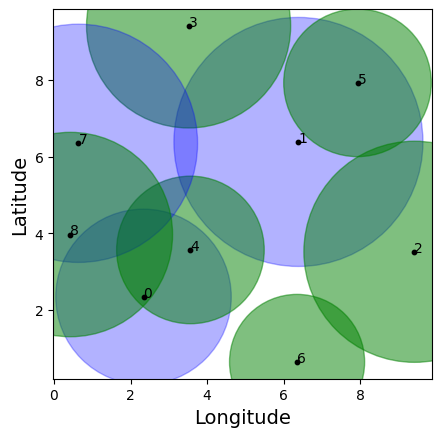

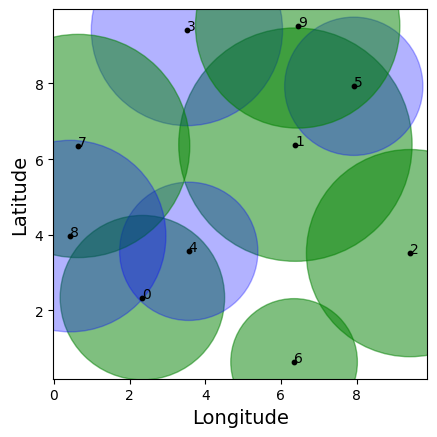

In [5]:
#Exact diagonalization
for ii, elem in enumerate(params):
    H_ed = mlist[ii].build_ham_sparse(ops=qtl.operators.TNSpin12Operators(),params=params[ii])
    start_time = time.time()
    eigenvalues, eigenvectors = eigsh(H_ed, k=3, which='SA')
    dt = time.time() - start_time
    ed_qp = Statevector(eigenvectors[:,0]).probabilities_dict(decimals=8)
    print(dt_tn, dt, eigenvalues)
    bit_string_ed_list=[]
    cnt=0
    for bit_ed in ed_qp.keys():
        bit_string_ed_list.append([*bit_ed])
        plot_antennas(dlist[ii], status=bit_string_ed_list[cnt])
        plt.savefig('camera_placement_N'+str(elem['N'])+'_xi'+str(elem['xi'])+'_ed.pdf',bbox_inches='tight')
        cnt+=1

In [6]:
eigenvalues[0], energy

(-52.208427009523575, -52.20842700944127)

## Comments on the tasks

The tasks for this project are outlined in the README file. Here are a few more hints to solve the problem. Of course, feel free to express your creativity, if you find better performance indicators.


- This project is not devoted to model derivation/setup, but mostly on the analysis of the results. The main focus of this project is to analyse the performance scaling as a function of the dimensionality of the system. A plot of "metric" vs $N$ should be provided for each selected metrics. An estimate of the scaling of the various metrics in the Big-O notation should be provided (polynomial, exponential...?). What are the differences in terms of runtime and accuracy between the constrained and unconstrained cases?


- We start from a small instance with $N=16$, that you should be able to address directly with brute-force search (BF) in a matter of seconds. A problem with $N=32$ should also be solvable with BF, but could require minutes to hours depending on the efficiency/parallelism of your BF code. 


- The TN solver should work up to $N \approx 1000$ qubits. In the current version, the tensor-network solver can handle variables which are powers of 2, so the number of variables should be set to $N = 2^n$. For the purpose of this Hackathon, we suggest to explore powers of two at least up to $N=512$ ($n=9$).


- Imaginary-time and variational solvers have both internal hyper-parameters. Be sure to tune them properly to achieve good convergence!


- If you decide to use a commercial code (CPLEX or GUROBI), you will be able to get the exact solution up to $N=256$.


- If a metric requires the extraction of pseudorandom samples, please provide some estimate of the sampling uncertainty.


### Suggestion of performance metrics

The performance metrics of TN should include: 
- runtime of your solution
- best generated solution
- cost of the best solution
- distribution of the sampled solutions

For instances that you can solve exactly, you can also access the (single-instance) approximation ratio:

\begin{align}
\alpha(E) = \frac{E}{H_{\rm min}}
\end{align}

or 

\begin{align}
\alpha(E) = 1- \frac{E-H_{\rm min}}{H_{\rm max} - H_{\rm min}}
\end{align}

so you can compute:
- approximation ratio of expectation value ($E = \langle H \rangle$)
- approximation ratio of the best generated solution ($E = E_{\rm TN-best}$)
- probability of getting the exact/best solution 


HINT: Would you include the penalty when estimating $\alpha$? 


#### Thanks for your attention and have fun!

### Convergence parameters
For groundstate search we need:

- **Maximal bond dimension**: maximal bond dimension that can be reached in a tensor network = in every SVD decomposition we keep maximally "max_bond_dim" values

- **Cut ratio**: cut ration after which the singular values are discarded = when rescaling all the singular values with the largest singular value, we discard of them which are smaller than "cut_ratio"

- **Number of iterations** : number of sweeps in the DMRG groundstate search

### Define the simulation

Now we are ready to define the simulation with all this input. In qtealeaves, simulations are defined as the QuantumGreenTeaSimulation class.

In addition, we need to specify the following:
- tensor network type: 5 is for TTN, 6 is for MPS
- tensor backend: 2 means QTeaTensor

